In [2]:
# imports
import os
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore
import pandas as pd

### Run track2p

In [15]:
from track2p.t2p import run_t2p                     # main function that launches track2p
from track2p.ops.default import DefaultTrackOps     # default track2p options
# load default settings / parameters
track_ops = DefaultTrackOps()

In [16]:
# overwrite some defaults
track_ops.all_ds_path = [           # list of paths to datasets containing a `suite2p` folder
            '/Users/manonmantez/Desktop/jm038/2023-04-30_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-01_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-02_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-03_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-04_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-05_a',
            '/Users/manonmantez/Desktop/jm038/2023-05-06_a'
        ]

track_ops.save_path = '/Users/manonmantez/Desktop/jm038/'    # path where to save the outputs of algorithm 
                                                                            # (a 'track2p' folder will be created where figures for
                                                                            # visualisation and matrices of matches would be saved)

track_ops.reg_chan = 1              # channel to use for registration (0=functional, 1=anatomical) (use 0 if only recording gcamp!)
track_ops.iscell_thr = 0.5          # threshold for iscell (0.5 is a good value)
track_ops.transform_type='affine'


In [ ]:
# print all the settings / parameters used for running the algorithm
for attr, value in track_ops.__dict__.items():
    print(attr, '=', value)

In [ ]:
# run the algorithm
run_t2p(track_ops)

### Load 

In [17]:
# this is the directory that contains a /track2p folder that is output by running the track2p algorithm
t2p_save_path = '/Users/manonmantez/Desktop/jm038' # (change this based on your data)
plane = 'plane0' # which plane to process (the example dataset is single-plane)

In [18]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path, 'track2p', f'{plane}_match_mat.npy'), allow_pickle=True)
# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)


Datasets used for t2p:

/Users/manonmantez/Desktop/jm038/2023-04-30_a
/Users/manonmantez/Desktop/jm038/2023-05-01_a
/Users/manonmantez/Desktop/jm038/2023-05-02_a
/Users/manonmantez/Desktop/jm038/2023-05-03_a
/Users/manonmantez/Desktop/jm038/2023-05-04_a
/Users/manonmantez/Desktop/jm038/2023-05-05_a
/Users/manonmantez/Desktop/jm038/2023-05-06_a


In [19]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)

Datasets used for t2p:

/Users/manonmantez/Desktop/jm038/2023-04-30_a
/Users/manonmantez/Desktop/jm038/2023-05-01_a
/Users/manonmantez/Desktop/jm038/2023-05-02_a
/Users/manonmantez/Desktop/jm038/2023-05-03_a
/Users/manonmantez/Desktop/jm038/2023-05-04_a
/Users/manonmantez/Desktop/jm038/2023-05-05_a
/Users/manonmantez/Desktop/jm038/2023-05-06_a


### Generate grid

In [20]:
# load the suite2p output of the first dataset
s2p_path = os.path.join(track_ops.all_ds_path[0], 'suite2p', plane)

# load the ops and stat
ops_first = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
stat_first = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
iscell_first = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)
s2p_inds = np.arange(len(stat_first))

# filter stat based on the track2p probability
print(f'Filtering stat based on the track2p probability (iscell_thr={track_ops.iscell_thr})')
s2p_inds_iscell = s2p_inds[iscell_first[:, 0] > track_ops.iscell_thr]
stat_first_iscell = stat_first[iscell_first[:, 0] > track_ops.iscell_thr]
print(f'Filtered stat from {len(stat_first)} to {len(stat_first_iscell)} cells')

Filtering stat based on the track2p probability (iscell_thr=0.5)
Filtered stat from 3587 to 2190 cells


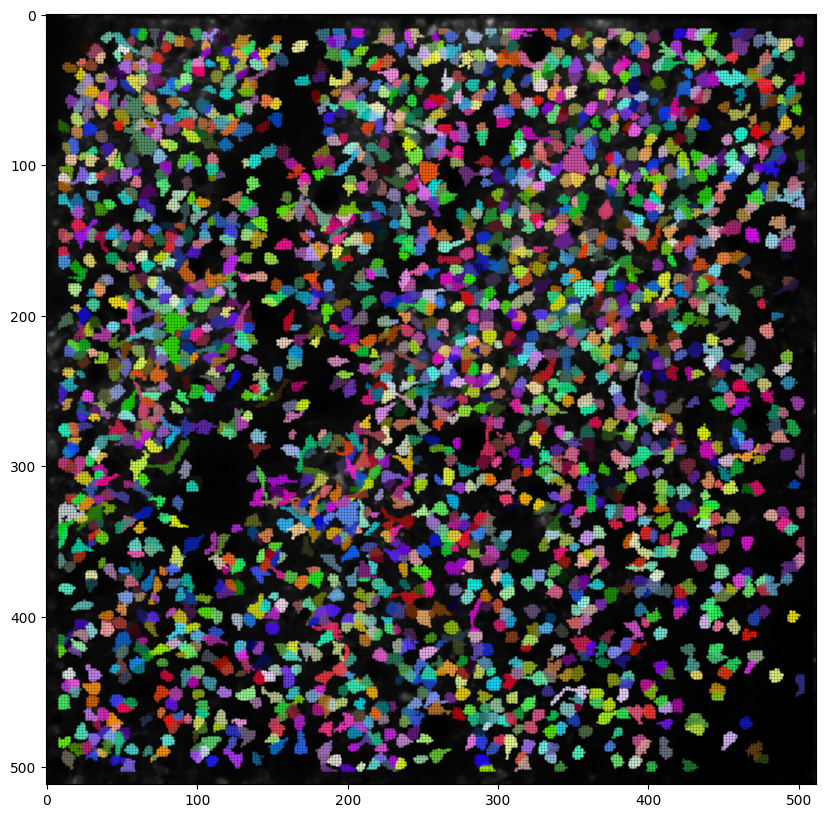

In [21]:
# now plot the fov with contours
plt.figure(figsize=(10, 10))
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(len(stat_first_iscell)):
    # get random color 
    color = np.random.rand(3)
    plt.scatter(stat_first_iscell[i]['xpix'], stat_first_iscell[i]['ypix'], s=1, color=color, alpha=0.5)

(-0.5, 511.5, 511.5, -0.5)

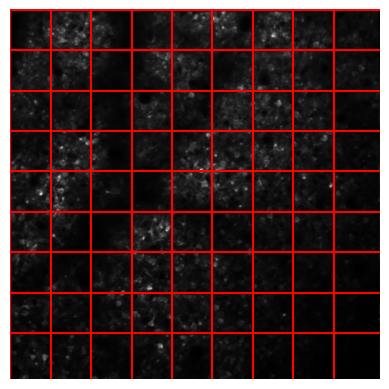

In [22]:
# now make a 8x8 grid on the image
n_grid = 9
grid_x = np.arange(0, ops_first['meanImg'].shape[1], ops_first['meanImg'].shape[1] // n_grid)
grid_y = np.arange(0, ops_first['meanImg'].shape[0], ops_first['meanImg'].shape[0] // n_grid)

plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='r')
    plt.axhline(grid_y[i], color='r')

plt.axis('off')

In [23]:
# now for each grid cross get the nearest cell (except for 0 and 512 pixels)
all_cell_med = []

# get all cell medians from stat
for i in range(len(stat_first_iscell)):
    all_cell_med.append(stat_first_iscell[i]['med'])
    

In [24]:
# compute coordinates of the grid crosses
grid_crosses = []
for i in range(1, n_grid):
    for j in range(1, n_grid):
        grid_crosses.append((grid_x[i], grid_y[j]))

grid_crosses

[(56, 56),
 (56, 112),
 (56, 168),
 (56, 224),
 (56, 280),
 (56, 336),
 (56, 392),
 (56, 448),
 (112, 56),
 (112, 112),
 (112, 168),
 (112, 224),
 (112, 280),
 (112, 336),
 (112, 392),
 (112, 448),
 (168, 56),
 (168, 112),
 (168, 168),
 (168, 224),
 (168, 280),
 (168, 336),
 (168, 392),
 (168, 448),
 (224, 56),
 (224, 112),
 (224, 168),
 (224, 224),
 (224, 280),
 (224, 336),
 (224, 392),
 (224, 448),
 (280, 56),
 (280, 112),
 (280, 168),
 (280, 224),
 (280, 280),
 (280, 336),
 (280, 392),
 (280, 448),
 (336, 56),
 (336, 112),
 (336, 168),
 (336, 224),
 (336, 280),
 (336, 336),
 (336, 392),
 (336, 448),
 (392, 56),
 (392, 112),
 (392, 168),
 (392, 224),
 (392, 280),
 (392, 336),
 (392, 392),
 (392, 448),
 (448, 56),
 (448, 112),
 (448, 168),
 (448, 224),
 (448, 280),
 (448, 336),
 (448, 392),
 (448, 448)]

(-0.5, 511.5, 511.5, -0.5)

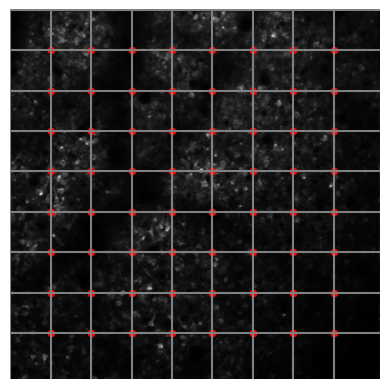

In [25]:
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='gray')
    plt.axhline(grid_y[i], color='gray')
for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='r')

plt.axis('off')


In [26]:
# compute distances between each cell and each grid cross
distances = np.zeros((len(stat_first_iscell), len(grid_crosses)))
for i, cell_med in enumerate(all_cell_med):
    for j, cross in enumerate(grid_crosses):
        distances[i, j] = np.sqrt((cell_med[0] - cross[0])**2 + (cell_med[1] - cross[1])**2)

In [27]:
# now get the nearest cell for each grid cross
nearest_cells = np.argmin(distances, axis=0)
nearest_cells

array([1494, 1140, 1449,  265, 1146,  924,  177, 2168, 1172,  913, 1927,
       1002, 1454,  237,  505, 1722, 1304, 1943, 1190, 1987,  429, 1490,
       2153,  364,  139, 1320, 1975,  533,  445, 1506, 1213,  880,  111,
       1217, 1520,  279, 1831, 1698,  582, 1829,  811, 1678,   79, 1293,
       1672, 1382, 1988,  980,   66, 1083,  814,   68, 1992,  856, 1679,
       1424, 1612,  984, 1258,  368,  610,  721, 1085, 2055])

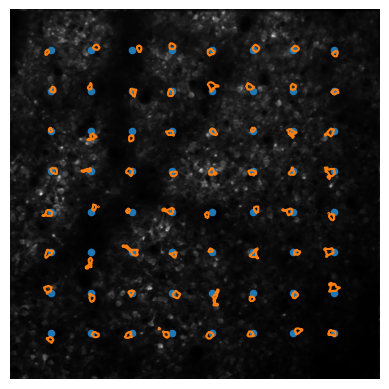

In [28]:
plt.imshow(ops_first['meanImg'], cmap='gray')

for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='C0')

plt.axis('off')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')


In [29]:
# now get the original indices
original_indices = s2p_inds_iscell[nearest_cells]
print('Now open suite2p and try to manually track cells:')
[print(f'{original_indices[i]}') for i in range(len(original_indices))]

Now open suite2p and try to manually track cells:
1779
1254
1708
267
1263
985
179
3480
1301
973
2719
1083
1717
239
511
2212
1480
2751
1326
2874
432
1773
3425
366
141
1506
2840
540
448
1796
1356
935
113
1362
1817
281
2450
2166
592
2447
853
2124
81
1464
2115
1601
2875
1059
67
1181
856
70
2881
905
2126
1672
1990
1065
1419
370
622
746
1183
3060


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-0.5, 511.5, 511.5, -0.5)

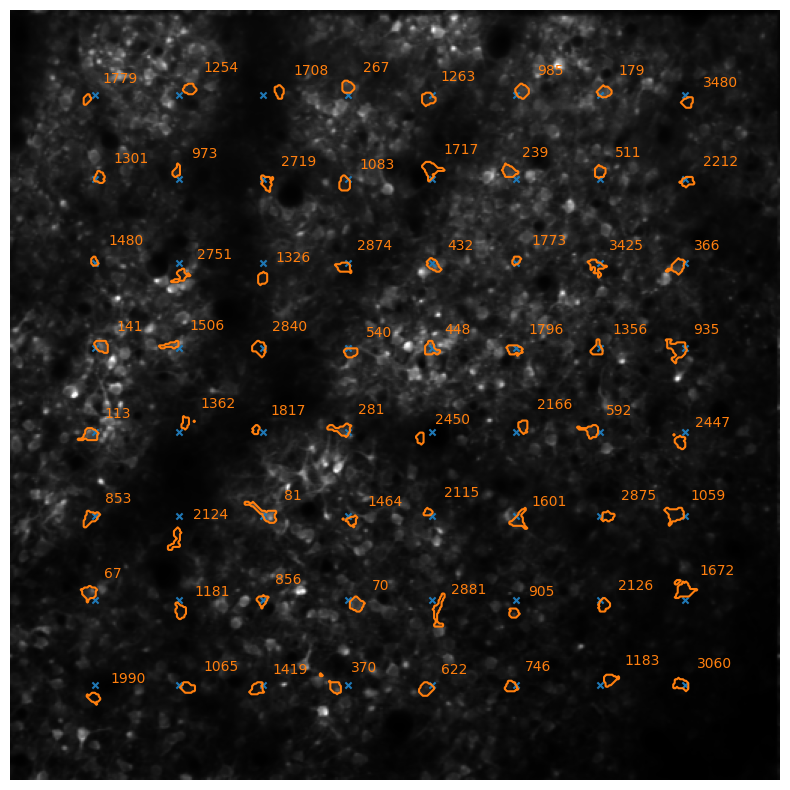

In [30]:
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices[i]}', color='C1')
    plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')

### Getting real suite2p indexes to compare it to

In [31]:
def function(path,plane,t2p_match_mat,track_ops):
    
    if track_ops.iscell_thr is not None:
        true_indices= np.empty((len(t2p_match_mat), len(track_ops.all_ds_path)))
        
    for j in range(len(t2p_match_mat)):
        for (i, ds_path) in enumerate(track_ops.all_ds_path):
            iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
            if track_ops.iscell_thr is not None:
                s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
                t2p_index=t2p_match_mat[j,i]

                if t2p_index is None:
                    true_index = None
                else:
                    true_index=s2p_indexes[t2p_index]

                true_indices[j, i] = true_index
            else:
                pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices.npy"), true_indices.astype(int))
        print("saved")
    else:
        print("not in locals")
        

In [32]:
function(t2p_save_path,plane,t2p_match_mat,track_ops)

saved


In [33]:
true_indices= np.load(os.path.join(t2p_save_path,"true_indices.npy"))
true_indices

array([[   0,    2,   36, ...,  456,   21,  202],
       [   1,   60,   13, ...,   14,   47,   55],
       [   2,   16,   88, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [3581, 2320,  930, ...,  876,  559,  930],
       [   0,    0,    0, ...,    0,    0,    0]])

In [34]:
np.sort(original_indices)

array([  67,   70,   81,  113,  141,  179,  239,  267,  281,  366,  370,
        432,  448,  511,  540,  592,  622,  746,  853,  856,  905,  935,
        973,  985, 1059, 1065, 1083, 1181, 1183, 1254, 1263, 1301, 1326,
       1356, 1362, 1419, 1464, 1480, 1506, 1601, 1672, 1708, 1717, 1773,
       1779, 1796, 1817, 1990, 2115, 2124, 2126, 2166, 2212, 2447, 2450,
       2719, 2751, 2840, 2874, 2875, 2881, 3060, 3425, 3480])

In [35]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs = []
for idx in np.sort(original_indices):
    idx_row = np.where(true_indices[:,0]==idx)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        print('here')
    else:
        s2p_idxs = true_indices[idx_row]

    all_s2p_idxs.append(s2p_idxs[0])


all_s2p_idxs = np.array(all_s2p_idxs)

#print(all_s2p_idxs.dtype)
print(all_s2p_idxs)

here
here
here
here
here
here
here
here
here
here
here
here
[array([ 67,  38,  15, 169,   0,   0,   0])
 array([ 70, 193, 224, 119, 120, 199,  76])
 array([ 81, 187,  65,  50,  21, 129,  11])
 array([113,  67, 170,  46, 487,  32,  99])
 array([ 141,  140,  553,  713, 1116,   10,   12])
 array([179, 521, 823, 230,   0,   0,   0])
 array([239, 154, 417,  16,  52,  94,  30])
 array([267, 313,  38,   0,   0,   0,   0])
 array([281, 953, 294, 208,  26,  80,  84])
 array([366, 118, 150,  36,  19,  26, 218])
 array([ 370,  786, 1271,  842,  421,  472,  488])
 array([432, 538, 370, 612, 188, 722, 510])
 array([ 448, 3060,    0,    0,    0,    0,    0])
 array([511, 874, 880,   0,   0,   0,   0]) None None
 array([ 622,  434, 1141,  888, 1133, 1789,    0])
 array([ 746, 1285, 1446,    0,    0,    0,    0]) None
 array([ 856, 1163, 1085, 1056,  441,  465,  688]) None
 array([ 935,  547, 1244,  212,  331,  531, 1161]) None
 array([985, 669,   0,   0,   0,   0,   0]) None
 array([1065,  410,  563,

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Comparing to manual evaluation

In [55]:
manual_matches = np.genfromtxt(os.path.join(t2p_save_path,'manual_matches.csv'), delimiter=';', skip_header=1) # convert csv to np
manual_matches= manual_matches.astype(int) # same as all_s2p_idxs
manual_matches

array([[  67,   38,   15,  169,    0,    0,    0],
       [  70,  193,  224,  119,  120,  199,   76],
       [  81,  187,   65,   50,   21,  129,   11],
       [ 113,   67,  170,   46,  487,  243,  464],
       [ 141,  140,  553,  713, 1116,   10,   12],
       [ 179,  521,  823,  230,    0,    0,    0],
       [ 239,  154,  417,   16,   52,   94,   30],
       [ 267,  313,   38,    0,    0,    0,    0],
       [ 281,  953,  294,  208,   26,   80,   84],
       [ 366,  118,  150,   36,   19,   26,  218],
       [ 370,  786, 1271,  842,  421,  472,  488],
       [ 432,  538,  370,  612,  188,  722,  510],
       [ 448, 3060,    0,    0,    0,    0,    0],
       [ 511,  874,  880,    0,    0,    0,    0],
       [ 540,    0,    0,    0,    0,    0,    0],
       [ 592,    0,    0,    0,    0,    0,    0],
       [ 622,  434, 1141,  888, 1133, 1789,    0],
       [ 746, 1285, 1446,    0,    0,    0,    0],
       [ 853, 1058,  554, 1234, 1099, 1158,  588],
       [ 856, 1163, 1085, 1056,

In [56]:
manual_matches_list = manual_matches.tolist()
manual_matches_list

[[67, 38, 15, 169, 0, 0, 0],
 [70, 193, 224, 119, 120, 199, 76],
 [81, 187, 65, 50, 21, 129, 11],
 [113, 67, 170, 46, 487, 243, 464],
 [141, 140, 553, 713, 1116, 10, 12],
 [179, 521, 823, 230, 0, 0, 0],
 [239, 154, 417, 16, 52, 94, 30],
 [267, 313, 38, 0, 0, 0, 0],
 [281, 953, 294, 208, 26, 80, 84],
 [366, 118, 150, 36, 19, 26, 218],
 [370, 786, 1271, 842, 421, 472, 488],
 [432, 538, 370, 612, 188, 722, 510],
 [448, 3060, 0, 0, 0, 0, 0],
 [511, 874, 880, 0, 0, 0, 0],
 [540, 0, 0, 0, 0, 0, 0],
 [592, 0, 0, 0, 0, 0, 0],
 [622, 434, 1141, 888, 1133, 1789, 0],
 [746, 1285, 1446, 0, 0, 0, 0],
 [853, 1058, 554, 1234, 1099, 1158, 588],
 [856, 1163, 1085, 1056, 441, 0, 0],
 [905, 0, 0, 0, 0, 0, 0],
 [935, 547, 1133, 723, 130, 871, 624],
 [973, 0, 0, 0, 0, 0, 0],
 [985, 669, 0, 0, 0, 0, 0],
 [1059, 0, 0, 0, 0, 0, 0],
 [1065, 410, 563, 920, 1258, 681, 705],
 [1083, 913, 335, 377, 636, 713, 788],
 [1181, 1185, 652, 785, 1515, 992, 0],
 [1183, 0, 0, 0, 0, 0, 0],
 [1254, 2028, 0, 0, 0, 0, 0],
 [126

In [57]:
for i in range(len(manual_matches)):
    # print the rows
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {manual_matches[i]}')
    print('')

track2p:     [ 67  38  15 169   0   0   0]
manual:      [ 67  38  15 169   0   0   0]

track2p:     [ 70 193 224 119 120 199  76]
manual:      [ 70 193 224 119 120 199  76]

track2p:     [ 81 187  65  50  21 129  11]
manual:      [ 81 187  65  50  21 129  11]

track2p:     [113  67 170  46 487  32  99]
manual:      [113  67 170  46 487 243 464]

track2p:     [ 141  140  553  713 1116   10   12]
manual:      [ 141  140  553  713 1116   10   12]

track2p:     [179 521 823 230   0   0   0]
manual:      [179 521 823 230   0   0   0]

track2p:     [239 154 417  16  52  94  30]
manual:      [239 154 417  16  52  94  30]

track2p:     [267 313  38   0   0   0   0]
manual:      [267 313  38   0   0   0   0]

track2p:     [281 953 294 208  26  80  84]
manual:      [281 953 294 208  26  80  84]

track2p:     [366 118 150  36  19  26 218]
manual:      [366 118 150  36  19  26 218]

track2p:     [ 370  786 1271  842  421  472  488]
manual:      [ 370  786 1271  842  421  472  488]

track2p:     [4

In [58]:
for i in range(len(manual_matches_list)):
    # Vérifier si tous les éléments sauf le premier sont des zéros
    if all(x == 0 for x in manual_matches_list[i][1:]):
        manual_matches_list[i] = None
    
    # Afficher les lignes
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {manual_matches_list[i]}')
    print('')

track2p:     [ 67  38  15 169   0   0   0]
manual:      [67, 38, 15, 169, 0, 0, 0]

track2p:     [ 70 193 224 119 120 199  76]
manual:      [70, 193, 224, 119, 120, 199, 76]

track2p:     [ 81 187  65  50  21 129  11]
manual:      [81, 187, 65, 50, 21, 129, 11]

track2p:     [113  67 170  46 487  32  99]
manual:      [113, 67, 170, 46, 487, 243, 464]

track2p:     [ 141  140  553  713 1116   10   12]
manual:      [141, 140, 553, 713, 1116, 10, 12]

track2p:     [179 521 823 230   0   0   0]
manual:      [179, 521, 823, 230, 0, 0, 0]

track2p:     [239 154 417  16  52  94  30]
manual:      [239, 154, 417, 16, 52, 94, 30]

track2p:     [267 313  38   0   0   0   0]
manual:      [267, 313, 38, 0, 0, 0, 0]

track2p:     [281 953 294 208  26  80  84]
manual:      [281, 953, 294, 208, 26, 80, 84]

track2p:     [366 118 150  36  19  26 218]
manual:      [366, 118, 150, 36, 19, 26, 218]

track2p:     [ 370  786 1271  842  421  472  488]
manual:      [370, 786, 1271, 842, 421, 472, 488]

track2

In [59]:
matches=[]
mismacthes=[]

for i in range(len(manual_matches_list)):
    if np.array_equal(all_s2p_idxs[i], manual_matches_list[i]):
        matches.append(i)
    else:
        mismacthes.append(i)

print(f'matches indexes: {matches}')
print(f'mismatches indexes: {mismacthes} \n')

print('Mismatches: \n')
for i in mismacthes:
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {manual_matches_list[i]}')
    print('')

matches indexes: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63]
mismatches indexes: [3, 18, 19, 21, 34, 44, 47, 57] 

Mismatches: 

track2p:     [113  67 170  46 487  32  99]
manual:      [113, 67, 170, 46, 487, 243, 464]

track2p:     None
manual:      [853, 1058, 554, 1234, 1099, 1158, 588]

track2p:     [ 856 1163 1085 1056  441  465  688]
manual:      [856, 1163, 1085, 1056, 441, 0, 0]

track2p:     [ 935  547 1244  212  331  531 1161]
manual:      [935, 547, 1133, 723, 130, 871, 624]

track2p:     [1362 1958 2054 2293 2717 1542 1934]
manual:      [1362, 1958, 2054, 2293, 0, 0, 0]

track2p:     [1779 1446  817  990    0    0    0]
manual:      [1779, 1446, 0, 0, 0, 0, 0]

track2p:     [1990  954 1148 1782    0    0    0]
manual:      None

track2p:     [2840 1767 1015 1163 1145    0    0]
manual:      None



In [ ]:
TP=[]
# True positive : we detect cell on all days and track2p detects on all days + the indexes match
FP=[]
#False positive:
#We don't detect cell on all days but track2p does
#We detect cell on all days and track2p also but not same indexes
TN=[]
#True negative:
#We don’t detect cell on all days, track2p doesn’t detect the cell on all days + the indexes match
FN=[]
#False negative:
#We detect cell on all days but track2p doesn’t
#We don’t detect cell on all days and track2p also but not same indexes

In [ ]:
Recall= len(TP)/(len(TP)+len(FN))
Precision= len(TP)/(len(TP)+len(FP))

Specificity= len(TN)/(len(TN)+len(FP))
Accuracy= (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))

F1_score= 2*(Precision*Recall)/(Precision+Recall)

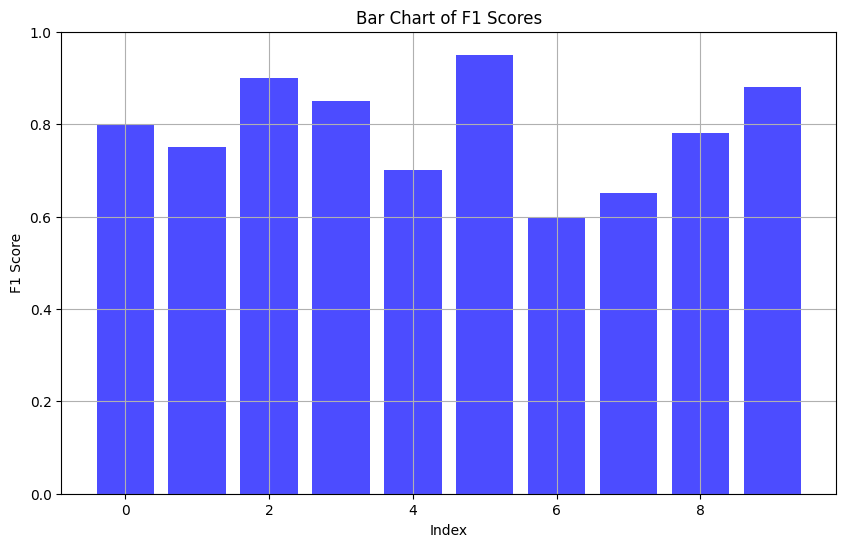

In [61]:


import matplotlib.pyplot as plt

def plot_f1_bar(f1_scores):
 
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(f1_scores)), f1_scores, color='blue', alpha=0.7)
    plt.title('Bar Chart of F1 Scores')
    plt.xlabel('Index')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)  # Assuming F1 scores are between 0 and 1
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
f1_scores = [0.8, 0.75, 0.9, 0.85, 0.7, 0.95, 0.6, 0.65, 0.78, 0.88]
plot_f1_bar(f1_scores)

#P8-P9